In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pinot
import torch
from matplotlib import pyplot as plt
import numpy as np
import scipy

Using backend: pytorch


In [44]:
ds_all = pinot.data.moonshot_with_date()

ds_all_ = ds_all.filter_by_time(after='1989-06-04')
# ds_all =  pinot.data.utils.batch(ds_all_, len(ds_all_))
ds_all_ = [(g, y[3][None]) for g, y in ds_all_ if ~torch.isnan(y[3])]
ds_all_ =  pinot.data.utils.batch(ds_all_, len(ds_all_))

g_all, y_all = pinot.data.utils.batch(ds_all_, len(ds_all_))[0]


In [26]:
ds_0 = ds_all.filter_by_time(before='2020-05-12')
ds_1 = ds_all.filter_by_time(before='2020-05-19')
ds_2 = ds_all.filter_by_time(before='2020-05-26')
ds_3 = ds_all.filter_by_time(before='2020-06-02')




collection = [
    ds_0,
    ds_1,
    ds_2,
    ds_3,
    ]


collection = [[(g, y[3][None]) for g, y in ds if ~torch.isnan(y[3])] for ds in collection]


collection = [
    pinot.data.utils.batch(ds, len(ds)) for ds in collection
]



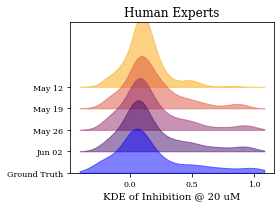

In [70]:
plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)




x_space = np.linspace(y_all.min(), y_all.max(), 100)

cmap=plt.get_cmap('inferno')

spacing = 1.0

plt.figure(figsize=(4, 3))

for idx in range(4):
    
    ds = collection[idx]
    
    net = pinot.Net(
        representation=pinot.representation.Sequential(
            layer=pinot.representation.dgl_legacy.gn(),
            config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
            output_regressor=pinot.regressors.ExactGaussianProcessRegressor)
    
    optimizer = torch.optim.Adam(net.parameters(), 1e-3)
    
    train = pinot.Train(
        net=net,
        data=ds,
        n_epochs=10,
        optimizer=optimizer
        )
    
    net = train.train()
    
    y_pred = net.condition(g_all).mean.detach().numpy()
    
    
    kde = scipy.stats.gaussian_kde(y_pred)(x_space)
    
    plt.fill_between(
        x_space,
        y1=spacing * (4 - idx),
        y2=kde + spacing * (4 - idx), 
        alpha=0.5, 
        # label=idx, 
        zorder=idx, 
        color=cmap(1.0 - float(idx / 5) - 0.2))
        

        
y_all = collection[3][0][1]
kde = scipy.stats.gaussian_kde(y_all.flatten().numpy())(x_space)
    
plt.fill_between(
    x_space,
    y1= 0.0, # spacing * 4,
    y2= kde, # + spacing * 4,
    alpha=0.5, 
    zorder=idx, 
    color='blue')

plt.yticks(
    ticks=[idx * spacing for idx in range(5)],
    labels=[
        
        'Ground Truth',
        'Jun 02',
        'May 26',
        'May 19',
        'May 12'
    ]
)

plt.xticks([0, 0.5, 1])

plt.xlabel('KDE of Inhibition @ 20 uM')
plt.title('Human Experts')

plt.ylim(0, spacing * 7)

plt.tight_layout()
plt.savefig('kde_human.png', dpi=500)
    

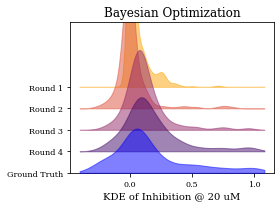

In [69]:
plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)



x_space = np.linspace(y_all.min(), y_all.max(), 100)

cmap=plt.get_cmap('inferno')

spacing = 1.0

plt.figure(figsize=(4, 3))

net = pinot.Net(
    representation=pinot.representation.Sequential(
        layer=pinot.representation.dgl_legacy.gn(),
        config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
        output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

optimizer = torch.optim.Adam(net.parameters(), 1e-3)

acquisition = pinot.active.acquisition.probability_of_improvement


bo = pinot.active.experiment.BayesOptExperiment(
    net=net,
    acquisition=acquisition,
    q=96,
    optimizer=optimizer,
    data=ds_all_[0],
    slice_fn=pinot.active.experiment._slice_fn_tuple, # pinot.active.
    collate_fn=pinot.active.experiment._collate_fn_graph, # pinot.active.
    n_epochs=10,
    )


bo.blind_pick(seed=None)
bo.update_data()


for idx in range(4):
    
    bo.train()
    bo.acquire()
    bo.update_data()


    
    y_pred = bo.net.condition(g_all).mean.detach().numpy()
    
    
    kde = scipy.stats.gaussian_kde(y_pred)(x_space)
    
    plt.fill_between(
        x_space,
        y1=spacing * (4 - idx),
        y2=kde + spacing * (4 - idx), 
        alpha=0.5, 
        # label=idx, 
        zorder=idx, 
        color=cmap(1.0 - float(idx / 5) - 0.2))
        

        
y_all = collection[3][0][1]
kde = scipy.stats.gaussian_kde(y_all.flatten().numpy())(x_space)
    
plt.fill_between(
    x_space,
    y1=0.0,
    y2= kde, # + spacing * 4,
    alpha=0.5, 
    zorder=idx, 
    color='blue')

plt.yticks(
    ticks=[idx * spacing for idx in range(5)],
    labels=[
        'Ground Truth',
        'Round 4',
        'Round 3',
        'Round 2',
        'Round 1',
        
    ]
)


plt.xticks([0, 0.5, 1])

plt.xlabel('KDE of Inhibition @ 20 uM')
plt.title('Bayesian Optimization')

plt.ylim(0, spacing * 7)

plt.tight_layout()
plt.savefig('kde_us.png', dpi=500)
    


